**Connect to Drive**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler

#Preprocess dataset

**Data Preparation and Initial Analysis**

In [ ]:
#import library
import pandas as pd
# path to files
file1 = "/content/drive/MyDrive/dtd/2015/diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
file2 = "/content/drive/MyDrive/dtd/2021/diabetes_binary_5050split_health_indicators_BRFSS2021.csv"
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# combine 2 dataframes
combined_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# rename column
combined_df.rename(columns={"Diabetes_binary": "Diabetes"}, inplace=True)

# show some rows
combined_df_info = combined_df.head(), combined_df.shape
combined_df_info  # output

(   Diabetes  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
 0       0.0     1.0       0.0        1.0  26.0     0.0     0.0   
 1       0.0     1.0       1.0        1.0  26.0     1.0     1.0   
 2       0.0     0.0       0.0        1.0  26.0     0.0     0.0   
 3       0.0     1.0       1.0        1.0  28.0     1.0     0.0   
 4       0.0     0.0       0.0        1.0  29.0     1.0     0.0   
 
    HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
 0                   0.0           1.0     0.0  ...            1.0   
 1                   0.0           0.0     1.0  ...            1.0   
 2                   0.0           1.0     1.0  ...            1.0   
 3                   0.0           1.0     1.0  ...            1.0   
 4                   0.0           1.0     1.0  ...            1.0   
 
    NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
 0          0.0      3.0       5.0      30.0       0.0  1.0   4.0        6.0   
 1          0.

**Removing Features**


In [ ]:
# remove irrelevant features
columns_to_remove = ["CholCheck", "AnyHealthcare", "NoDocbcCost", "Education", "Income"]
reduced_df = combined_df.drop(columns=columns_to_remove)

# reverse the values of "General Health"
# now scale is 1=poor to 5=excellent
reduced_df["GenHlth"] = 6 - reduced_df["GenHlth"]

# show some rows of the dataframe
reduced_df.head()

,Diabetes,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0
1,0.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0
2,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,5.0,0.0,10.0,0.0,1.0,13.0
3,0.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0
4,0.0,0.0,0.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,8.0


**Check for Missing Values**

In [ ]:
# check for missing values
missing_values = reduced_df.isnull().sum()
missing_values

Diabetes                0
HighBP                  0
HighChol                0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
dtype: int64

**Data Type Optimization Analysis**


In [ ]:
# check range of values of specified features to determine suitable data types
features_to_optimize = ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age"]
data_types_optimization = (
    reduced_df[features_to_optimize].describe().loc[["min", "max"]]
)
data_types_optimization

,BMI,GenHlth,MentHlth,PhysHlth,Age
min,12.0,1.0,0.0,0.0,1.0
max,99.0,5.0,30.0,30.0,13.0


**Data Type Conversion for Efficiency**

In [ ]:
# memory used before reducing data types
memory_before = reduced_df.memory_usage(index=True).sum() / (1024 * 1024)  # convert bytes to MB

# scale data types down to reduce memory footprint
reduced_df["BMI"] = reduced_df["BMI"].astype("float32")
reduced_df["GenHlth"] = reduced_df["GenHlth"].astype("int8")
reduced_df["MentHlth"] = reduced_df["MentHlth"].astype("int8")
reduced_df["PhysHlth"] = reduced_df["PhysHlth"].astype("int8")
reduced_df["Age"] = reduced_df["Age"].astype("int8")

# convert 1/0 binary columns to boolean values
binary_columns = [
    "Diabetes",
    "HighBP",
    "HighChol",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "DiffWalk",
    "Sex",
]
for column in binary_columns:
    reduced_df[column] = reduced_df[column].astype("bool")

# memory size after data type reduction
memory_after = reduced_df.memory_usage(index=True).sum() / (1024 * 1024)  # Convert bytes to MB

print("Dataframe memory used:\n")
print("Before:", memory_before, "MB")
print("After:", memory_after, "MB")


Dataframe memory used:

Before: 17.876373291015625 MB
After: 2.6289825439453125 MB


#Data Exploration

**General health with Diabetes status**

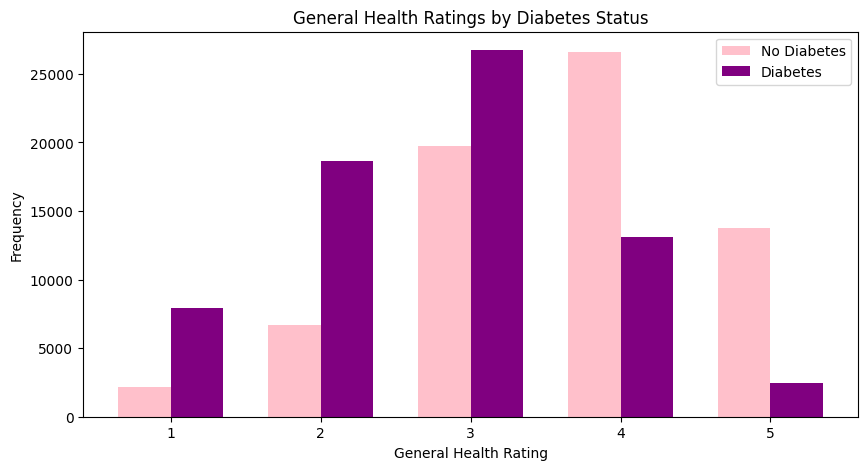

In [ ]:
# Filter the dataframe to get the "General Health" ratings for individuals without diabetes
gen_health_no_diabetes = reduced_df[reduced_df["Diabetes"] == False]["GenHlth"]
# Filter the dataframe to get the "General Health" ratings for individuals with diabetes
gen_health_with_diabetes = reduced_df[reduced_df["Diabetes"] == True]["GenHlth"]

# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Define the width of each bar
bar_width = 0.35

# Define the positions for the bars
positions_no_diabetes = np.arange(1, 6)
positions_with_diabetes = positions_no_diabetes + bar_width

# Plot the bars for "General Health" ratings for individuals without diabetes
ax.bar(
    positions_no_diabetes,
    gen_health_no_diabetes.value_counts().sort_index(),
    bar_width,
    color='pink',
    label="No Diabetes"
)
# Plot the bars for "General Health" ratings for individuals with diabetes
ax.bar(
    positions_with_diabetes,
    gen_health_with_diabetes.value_counts().sort_index(),
    bar_width,
    color='purple',
    label="Diabetes"
)

# Add a legend to differentiate between the two groups
ax.legend()
# Add title and axis labels to the plot
ax.set_title("General Health Ratings by Diabetes Status")
ax.set_xlabel("General Health Rating")
ax.set_ylabel("Frequency")
# Set the x-axis ticks to range from 1 to 5 (representing the General Health rating scale)
ax.set_xticks(np.arange(1, 6) + bar_width / 2)
ax.set_xticklabels(np.arange(1, 6))
# Display the plot
plt.show()


**Analysis of physical health comparing diabetics to non-diabetics.**

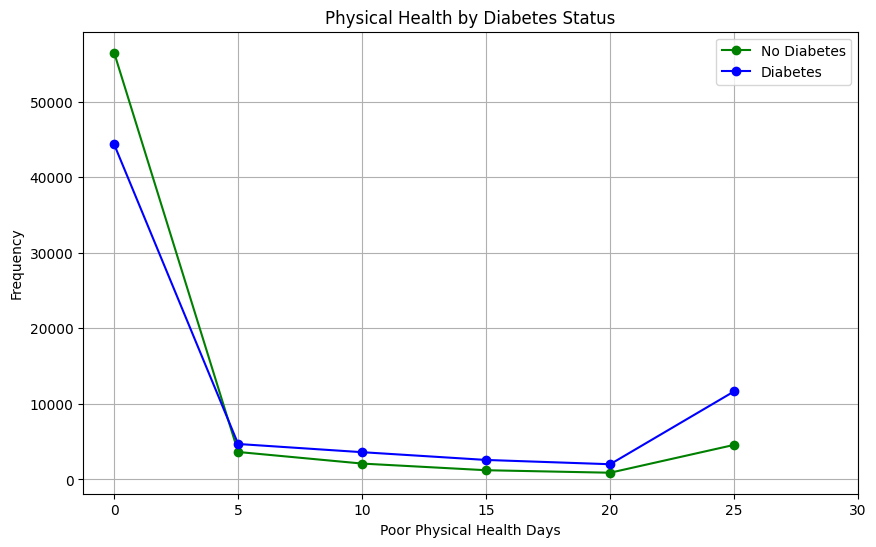

In [ ]:
# Filter the dataframe to get the "Physical Health" days for individuals without diabetes
phys_health_no_diabetes = reduced_df[reduced_df["Diabetes"] == False]["PhysHlth"]
# Filter the dataframe to get the "Physical Health" days for individuals with diabetes
phys_health_with_diabetes = reduced_df[reduced_df["Diabetes"] == True]["PhysHlth"]

# Calculate the bin edges for the histogram for individuals without diabetes
counts_no_diabetes, bin_edges_no_diabetes = np.histogram(phys_health_no_diabetes, bins=6)

# Calculate the bin edges for the histogram for individuals with diabetes
counts_with_diabetes, bin_edges_with_diabetes = np.histogram(phys_health_with_diabetes, bins=6)

# Set the positions for the x-axis ticks
positions = range(0, 31, 5)

# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the line chart for "Physical Health" days for individuals without diabetes
ax.plot(
    bin_edges_no_diabetes[:-1],
    counts_no_diabetes,
    marker='o',
    label="No Diabetes",
    color='green'
)

# Plot the line chart for "Physical Health" days for individuals with diabetes
ax.plot(
    bin_edges_with_diabetes[:-1],
    counts_with_diabetes,
    marker='o',
    label="Diabetes",
    color='Blue'
)

# Add a legend to the plot to differentiate between the two groups
ax.legend()

# Add title and axis labels to the plot
ax.set_title("Physical Health by Diabetes Status")
ax.set_xlabel("Poor Physical Health Days")
ax.set_ylabel("Frequency")

# Set the x-axis ticks to highlight milestone points
ax.set_xticks(positions)

# Display the plot
plt.grid(True)
plt.show()


**Analysis of mental health comparing diabetics to non-diabetics.**

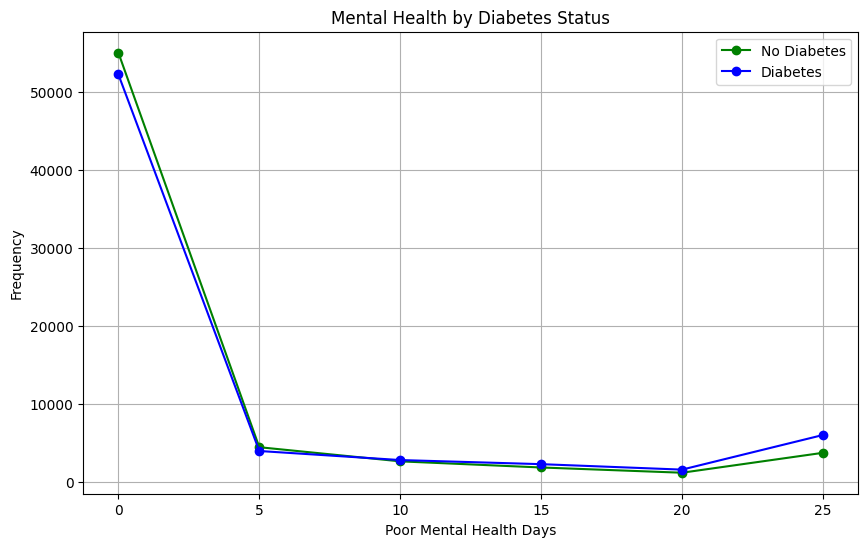

In [ ]:
# Filter the dataframe to get the "Mental Health" days for individuals without diabetes
ment_health_no_diabetes = reduced_df[reduced_df["Diabetes"] == False]["MentHlth"]
# Filter the dataframe to get the "Mental Health" days for individuals with diabetes
ment_health_with_diabetes = reduced_df[reduced_df["Diabetes"] == True]["MentHlth"]

# Calculate the bin edges for the histogram for individuals without diabetes
counts_no_diabetes, bin_edges_no_diabetes = np.histogram(ment_health_no_diabetes, bins=6)
# Calculate the bin edges for the histogram for individuals with diabetes
counts_with_diabetes, bin_edges_with_diabetes = np.histogram(ment_health_with_diabetes, bins=6)

# Set the positions for the x-axis ticks
positions = bin_edges_no_diabetes[:-1]
# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the line chart for "Mental Health" days for individuals without diabetes
ax.plot(
    positions,
    counts_no_diabetes,
    marker='o',
    label="No Diabetes",
    color='green'
)

# Plot the line chart for "Mental Health" days for individuals with diabetes
ax.plot(
    positions,
    counts_with_diabetes,
    marker='o',
    label="Diabetes",
    color='Blue'
)

# Add a legend to the plot to differentiate between the two groups
ax.legend()

# Add title and axis labels to the plot
ax.set_title("Mental Health by Diabetes Status")
ax.set_xlabel("Poor Mental Health Days")
ax.set_ylabel("Frequency")

# Set the x-axis ticks to highlight milestone points
ax.set_xticks(positions)

# Display the plot
plt.grid(True)
plt.show()


**Age distribution**

|Category|1|2|3|4|5|6|7|8|9|10|11|12|13|
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|Age range|18-24|25-29|30-34|35-39|40-44|45-49|50-54|55-59|60-64|65-69|70-74|75-79|80+|

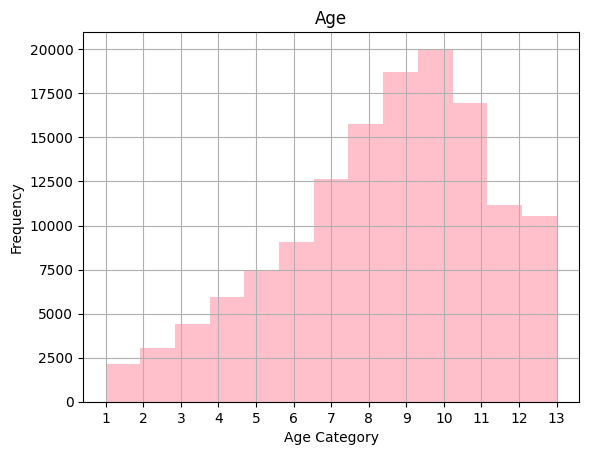

In [ ]:
# Plot Age histogram
graph_histograms = reduced_df.hist(column="Age", grid=True, bins=13, color='pink')

# Calculate the tick positions for 13 bins
tick_positions = range(1, 14)

# Set the x-axis ticks
plt.xticks(tick_positions)

# Optionally, set x-axis and y-axis labels
plt.xlabel("Age Category")
plt.ylabel("Frequency")

# Show the plot
plt.show()


**BMI over Age**

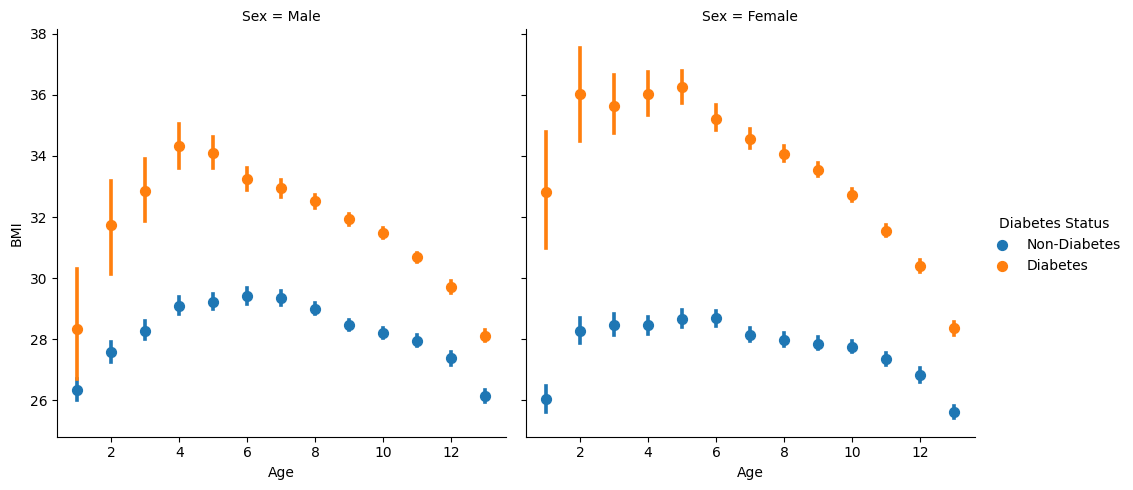

In [ ]:
# Copy the DataFrame to avoid modifying the original data
plot_df = reduced_df.copy()

# Map True/False to Male/Female
plot_df["Sex"] = plot_df["Sex"].map({True: "Male", False: "Female"})

# Map True/False to Diabetes/Non-Diabetes
plot_df["Diabetes Status"] = plot_df["Diabetes"].map({True: "Diabetes", False: "Non-Diabetes"})

# Age/BMI Scatterplot
sns.lmplot(
    data=plot_df,
    x="Age",
    y="BMI",
    col="Sex",
    hue="Diabetes Status",
    x_bins=1000,
    fit_reg=False,
)

# Show the plot
plt.show()


**General Health over Age**

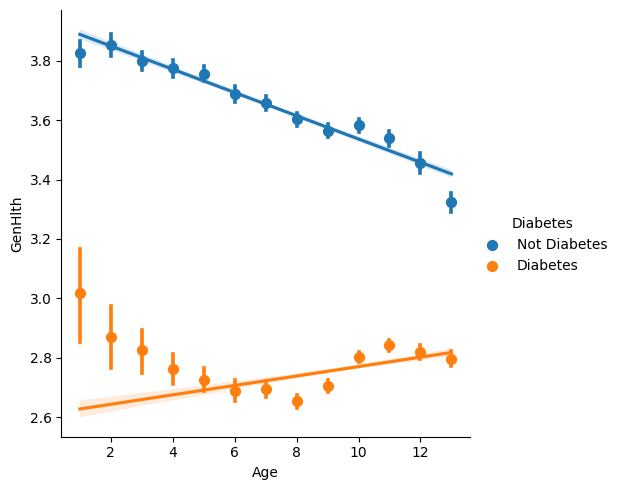

In [ ]:
# Copy the DataFrame to avoid modifying the original data
#plot_df1 = reduced_df.copy()
# Replace True and False values in "Diabetes" column with strings "Diabetes" and "Not Diabetes"
plot_df["Diabetes"] = reduced_df["Diabetes"].replace({True: "Diabetes", False: "Not Diabetes"})

# Scatterplot
sns.lmplot(
    data=plot_df,
    x="Age",
    y="GenHlth",
    hue="Diabetes",
    x_bins=1000
)

**Physical Health as compared to Mental health**

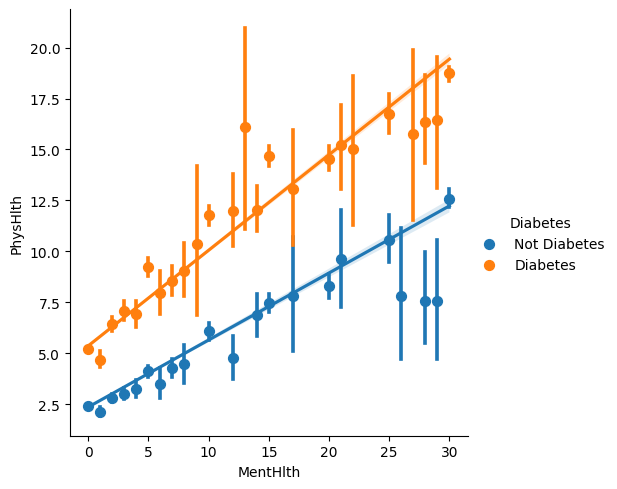

In [ ]:
# Replace True and False values in "Diabetes" column with strings "Diabetes" and "Not Diabetes"
plot_df["Diabetes"] = reduced_df["Diabetes"].replace({True: "Diabetes", False: "Not Diabetes"})

# Scatterplot
sns.lmplot(
    data=plot_df,
    x="MentHlth",
    y="PhysHlth",
    hue="Diabetes",
    x_bins=1000
)


# Train and Evaluation

**Logistic Regression Model for Diabetes Prediction**

In [ ]:
# Create a copy of the reduced dataframe for further processing
log_df = reduced_df.copy(deep=True)

# Define numerical columns for feature scaling
numerical_columns = ["BMI", "GenHlth", "MentHlth", "PhysHlth", "Age"]

# Initialize a MinMaxScaler to scale numerical features to a range between 0 and 1
scaler = MinMaxScaler()

# Scale the numerical columns in the dataframe using MinMaxScaler
log_df[numerical_columns] = scaler.fit_transform(log_df[numerical_columns])

# Initialize a logistic regression model with specified parameters
mylog_model = linear_model.LogisticRegression(solver="saga", max_iter=1000)

# Prepare the feature matrix X (all columns except "Diabetes") and the target vector y ("Diabetes")
X_log = log_df.drop("Diabetes", axis=1)
y_log = log_df["Diabetes"].astype("bool")  # Ensuring the target is boolean

# Split the data into training and testing sets
X_log_train, X_log_test, y_log_train, y_log_test = model_selection.train_test_split(
    X_log, y_log, test_size=0.25, random_state=42
)
# Train the logistic regression model on the training data
mylog_model.fit(X_log_train, y_log_train)

LogisticRegression(max_iter=1000, solver='saga')

**Save Model**

In [ ]:
import joblib
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# Save the trained model
joblib.dump(mylog_model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

**Evaluation**

In [ ]:
# Make predictions on the testing data
y_pred_log = mylog_model.predict(X_log_test)

# Evaluate the model's performance
accuracy_log = accuracy_score(y_log_test, y_pred_log)
class_report_log = classification_report(y_log_test, y_pred_log)

# Print the results
print("Logistic Regression prediction results:")
print(f"Accuracy: {round(accuracy_log*100,2)} %")
print("Classification Report:")
print(class_report_log)

Logistic Regression prediction results:
Accuracy: 74.58 %
Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.73      0.74     17213
        True       0.74      0.76      0.75     17244

    accuracy                           0.75     34457
   macro avg       0.75      0.75      0.75     34457
weighted avg       0.75      0.75      0.75     34457



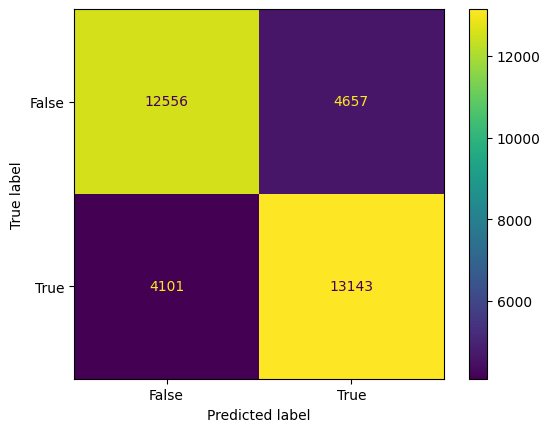

In [ ]:
# Plot confusion matrix
graph_confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_log_test, y_pred_log)

**Performance Measure**

In [ ]:
import time

# Start time
start_time = time.time()

# Make predictions
predictions = mylog_model.predict(X_log_test)

# End time
end_time = time.time()

# Calculate the time taken for predictions
prediction_time = end_time - start_time

print(f"Time taken for predictions: {prediction_time} seconds")


Time taken for predictions: 0.01905679702758789 seconds


**Random Forest Model for Diabetes Prediction**


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 'X' is the set of features and 'y' is the target variable
X_rf = reduced_df.drop("Diabetes", axis=1)
y_rf = reduced_df["Diabetes"].astype("bool")  # Ensuring the target is boolean
# Splitting the dataset into the Training set and Test set
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_rf, y_rf, test_size=0.25, random_state=42
)

# Creating a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting Random Forest to the Training set
rf_classifier.fit(X_rf_train, y_rf_train)

# Predicting the Test set results
y_pred_rf = rf_classifier.predict(X_rf_test)

# Predicting the Test set results
y_pred_rf = rf_classifier.predict(X_rf_test)
accuracy_rf = accuracy_score(y_rf_test, y_pred_rf)
class_report_rf = classification_report(y_rf_test, y_pred_rf)

# Evaluate the model
print("Random Forest results:")
print(f"Accuracy: {round(accuracy_rf*100,2)} %")
print("Classification Report:")
print(class_report_rf)

Random Forest results:
Accuracy: 72.13 %
Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.69      0.71     17213
        True       0.71      0.75      0.73     17244

    accuracy                           0.72     34457
   macro avg       0.72      0.72      0.72     34457
weighted avg       0.72      0.72      0.72     34457



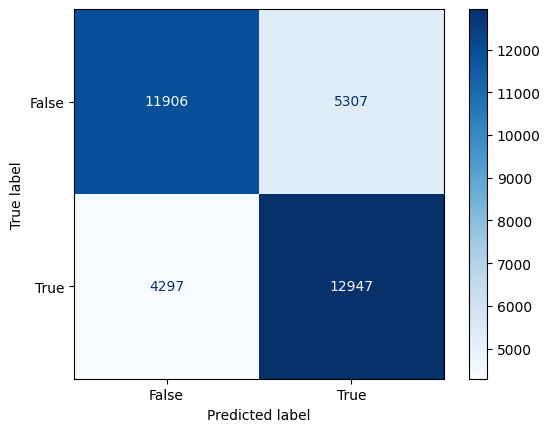

In [ ]:
# Plot confusion matrix
graph_confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_rf_test, y_pred_rf, cmap="Blues")

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# 'X' is the set of features and 'y' is the target variable
X_gb = reduced_df.drop("Diabetes", axis=1)
y_gb = reduced_df["Diabetes"].astype("bool")  # Ensuring the target is boolean

# Splitting the dataset into the Training set and Test set
X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(
    X_gb, y_gb, test_size=0.25, random_state=42
)

# Creating a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fitting Gradient Boosting to the Training set
gb_classifier.fit(X_gb_train, y_gb_train)

# Predicting the Test set results
y_pred_gb = gb_classifier.predict(X_gb_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_gb_test, y_pred_gb)
class_report_gb = classification_report(y_gb_test, y_pred_gb)

# Print the results
print("Gradient Boosting results:")
print(f"Accuracy: {round(accuracy_gb * 100, 2)} %")
print("Classification Report:")
print(class_report_gb)


Gradient Boosting results:
Accuracy: 75.2 %
Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.71      0.74     17213
        True       0.73      0.79      0.76     17244

    accuracy                           0.75     34457
   macro avg       0.75      0.75      0.75     34457
weighted avg       0.75      0.75      0.75     34457



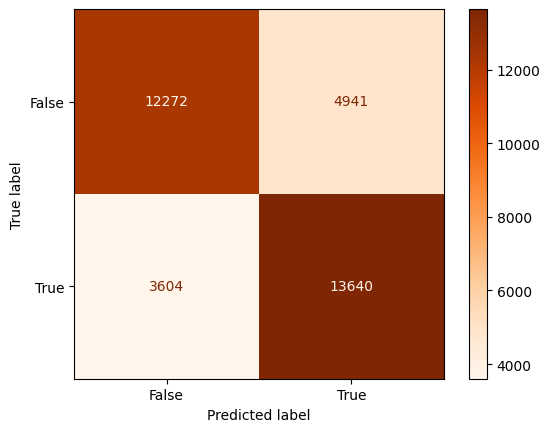

In [ ]:
# Plot confusion matrix
graph_confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_gb_test, y_pred_gb, cmap="Oranges")

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
# Verify model by averaging different test/train splits
k_folds = KFold(n_splits=5, shuffle=True)
# The number of folds determines the test/train split for each iteration.
# So 5 folds has 5 different mutually exclusive training sets.
# That's a 1 to 4 (or .20 to .80) testing/training split for each of the 5 iterations.

# This is the average score. Print 'scores' to see array of individual iteration scores.
log_scores = cross_val_score(mylog_model, X_log, y_log)
rf_scores = cross_val_score(rf_classifier, X_rf, y_rf)
gb_scores= cross_val_score(gb_classifier, X_gb, y_gb)

# Output average scores
print(
    "Logistic Regression Average Prediction Score: ",
    round(log_scores.mean() * 100, 2),
    "%",
)
print("Random Forest Average Prediction Score: ", round(rf_scores.mean() * 100, 2), "%")
print("Gradient Boosting Average Prediction Score: ", round(gb_scores.mean() * 100, 2), "%")

Logistic Regression Average Prediction Score:  74.25 %
Random Forest Average Prediction Score:  71.89 %
Gradient Boosting Average Prediction Score:  74.73 %


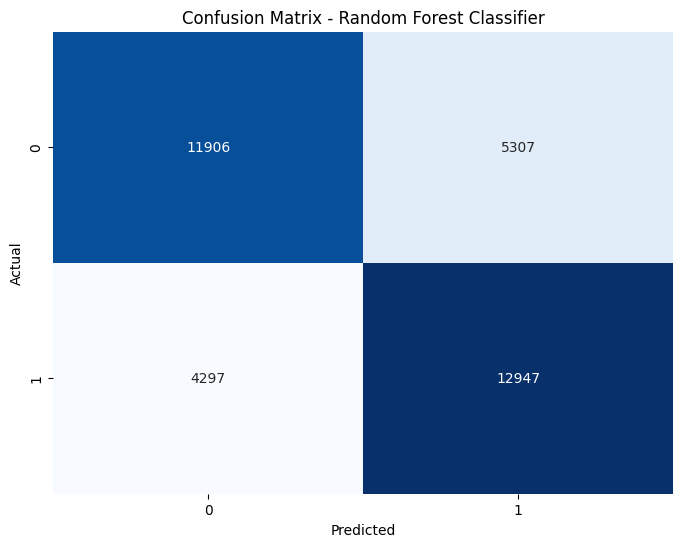

In [ ]:
#import library
from sklearn.ensemble import RandomForestClassifier

# Assuming X_rf_train, X_rf_test, y_rf_train, y_rf_test are already defined

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_rf_train, y_rf_train)

# Predict on the test data
y_pred_rf = rf_classifier.predict(X_rf_test)

# Generate the confusion matrix
conf_matrix_rf = confusion_matrix(y_rf_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()
